In [1]:
import os
import json
import re
from io import BytesIO
from pathlib import Path

import numpy as np
import pandas as pd
from google.cloud import storage

/Users/loso/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.6) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
def load_environment(env_path: str = ".env") -> tuple[str, str]:
    """Load GCP credentials and bucket name from a .env file (supports running from notebooks/)."""
    env_file = Path(env_path)

    # If running from notebooks/, fall back to parent .env
    if not env_file.is_file() and env_path == ".env":
        parent_env = Path.cwd().parent / ".env"
        if parent_env.is_file():
            env_file = parent_env

    if not env_file.is_file():
        raise FileNotFoundError(f".env file not found at {env_file}")

    for line in env_file.read_text().splitlines():
        stripped = line.strip()
        if not stripped or stripped.startswith("#") or "=" not in stripped:
            continue
        key, value = stripped.split("=", 1)
        key = key.strip()
        value = value.strip()
        if key in {"GOOGLE_APPLICATION_CREDENTIALS", "GCP_BUCKET_NAME"}:
            os.environ[key] = value

    credentials_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
    bucket_name = os.environ.get("GCP_BUCKET_NAME")

    if not credentials_path or not bucket_name:
        raise EnvironmentError(
            "GOOGLE_APPLICATION_CREDENTIALS and GCP_BUCKET_NAME must be set in the .env file."
        )

    credentials_file = Path(credentials_path)
    if not credentials_file.is_file():
        raise FileNotFoundError(f"Credentials file not found at {credentials_file}")

    print(f"Loaded credentials from: {credentials_file}")
    print(f"Using bucket: {bucket_name}")
    return str(credentials_file), bucket_name


In [3]:
def load_emg_dataframe_from_csv(env_path: str = ".env") -> pd.DataFrame:
    """Download the EMG CSV from GCS and return the raw DataFrame."""
    _, bucket_name = load_environment(env_path=env_path)

    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob_path = "EMG-nature/Clean_df/emg_trial_level_df.csv"

    print(f"Accessing blob: {blob_path}")
    blob = bucket.blob(blob_path)

    if not blob.exists(client=client):
        raise FileNotFoundError(f"Blob {blob_path} not found in bucket {bucket_name}")

    data_bytes = blob.download_as_bytes()
    print(f"Downloaded {len(data_bytes)} bytes from GCS")

    df = pd.read_csv(BytesIO(data_bytes))
    print(f"Loaded DataFrame with shape: {df.shape}")
    return df


In [4]:
def parse_signal_cell(cell: str | np.ndarray | list | tuple) -> np.ndarray:
    """Parse a corrupted/loosely formatted signal into a (16, N) float32 array."""
    # If already array-like, trust and reshape as needed.
    if isinstance(cell, (np.ndarray, list, tuple)):
        arr = np.asarray(cell, dtype=np.float32)
        if arr.shape == (16, 10000):
            return arr
        if arr.shape == (10000, 16):
            return arr.T
        if arr.ndim == 1 and arr.size == 160000:
            return arr.reshape(16, 10000)
        if arr.ndim == 2 and arr.shape[0] == 16:
            return arr

    raw = str(cell)
    tokens = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", raw)
    if not tokens:
        raise ValueError(f"No numeric tokens found in signal cell: {raw[:120]}")

    numbers = np.asarray([float(t) for t in tokens], dtype=np.float32)
    if numbers.size < 16:
        raise ValueError(f"Too few numeric tokens ({numbers.size}); sample: {raw[:120]}")

    usable = (numbers.size // 16) * 16
    numbers = numbers[:usable]
    channel_len = usable // 16
    if channel_len == 0:
        raise ValueError(f"Not enough data to form 16 channels; tokens={numbers.size}")

    arr = numbers.reshape(16, channel_len)
    return arr


def fix_length(arr: np.ndarray, target_len: int = 10000) -> np.ndarray:
    """Trim or pad signals to exactly (16, target_len)."""
    if arr.ndim != 2 or arr.shape[0] != 16:
        raise ValueError(f"Signal must have shape (16, N); got {arr.shape}")

    current_len = arr.shape[1]
    if current_len == target_len:
        return arr
    if current_len < target_len:
        pad_width = target_len - current_len
        return np.pad(arr, ((0, 0), (0, pad_width)), mode="constant")
    return arr[:, :target_len]


In [6]:
emg_df = load_emg_dataframe_from_csv()

# emg_df["signal"] = emg_df["signal"].apply(parse_signal_cell)
# emg_df["signal_fixed"] = emg_df["signal"].apply(fix_length)

# print(emg_df["signal_fixed"].apply(lambda x: x.shape).value_counts())
print(emg_df.head())
print(emg_df.shape)


Loaded credentials from: /Users/loso/code/hildieleyser/inkling/keys/inkling-479911-b140632c44c5.json
Using bucket: inkling-ssvep-emg
Accessing blob: EMG-nature/Clean_df/emg_trial_level_df.csv
Downloaded 3078852 bytes from GCS
Loaded DataFrame with shape: (4800, 8)
   Unnamed: 0  participant  day  block  trial_id  position  grasp  \
0           0            1    1      1         1         2      3   
1           1            1    1      1         2         2      3   
2           2            1    1      1         3         2      3   
3           3            1    1      1         4         2      3   
4           4            1    1      1         5         2      3   

                                              signal  
0  [[ 3.76349817e-05  1.98425078e-05  9.07169760e...  
1  [[ 1.05379877e-05  1.15394896e-05  1.18090165e...  
2  [[ 1.69775649e-05  1.99370879e-05  2.18309942e...  
3  [[ 3.6807487e-06  3.2587977e-06  2.3399070e-06...  
4  [[ 1.5383765e-05  1.8471881e-05  1.6300444

In [7]:
emg_df = emg_df.drop(columns = "Unnamed: 0")

In [13]:
emg_df['grasp'].value_counts()

grasp
3    800
1    800
4    800
5    800
2    800
6    800
Name: count, dtype: int64

In [14]:
emg_df.head()

,participant,day,block,trial_id,position,grasp,signal
0,1,1,1,1,2,3,[[ 3.76349817e-05 1.98425078e-05 9.07169760e...
1,1,1,1,2,2,3,[[ 1.05379877e-05 1.15394896e-05 1.18090165e...
2,1,1,1,3,2,3,[[ 1.69775649e-05 1.99370879e-05 2.18309942e...
3,1,1,1,4,2,3,[[ 3.6807487e-06 3.2587977e-06 2.3399070e-06...
4,1,1,1,5,2,3,[[ 1.5383765e-05 1.8471881e-05 1.6300444e-05...


In [20]:
len(emg_df['signal'][0])

635

In [ ]:
# emg_df = emg_df.drop(columns='signal_fixed')

In [ ]:
# emg_df['signal'].shape

(4800,)

In [9]:
emg_df['signal'].shape

(4800,)

In [11]:
emg_df['signal_fixed'].shape

(4800,)

In [ ]:
# emg_df = emg_df[emg_df['grasp'].isin([1, 5])]

In [7]:
# Example: Power (1) vs Wrist Extension (some grasp ID)
emg_df = emg_df[emg_df['grasp'].isin([1, 3])]  # 3 is just hypothetical


In [8]:
emg_df['grasp'].value_counts()

grasp
3    800
1    800
Name: count, dtype: int64

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score


In [11]:
emg_df

,participant,day,block,trial_id,position,grasp,signal,signal_fixed
0,1,1,1,1,2,3,"[[3.763498e-05, 1.9842508e-05], [9.071698e-06,...","[[3.763498e-05, 1.9842508e-05, 0.0, 0.0, 0.0, ..."
1,1,1,1,2,2,3,"[[1.0537988e-05, 1.153949e-05], [1.18090165e-0...","[[1.0537988e-05, 1.153949e-05, 0.0, 0.0, 0.0, ..."
2,1,1,1,3,2,3,"[[1.6977565e-05, 1.9937088e-05], [2.1830994e-0...","[[1.6977565e-05, 1.9937088e-05, 0.0, 0.0, 0.0,..."
3,1,1,1,4,2,3,"[[3.6807487e-06, 3.2587977e-06], [2.339907e-06...","[[3.6807487e-06, 3.2587977e-06, 0.0, 0.0, 0.0,..."
4,1,1,1,5,2,3,"[[1.5383765e-05, 1.8471881e-05], [1.6300444e-0...","[[1.5383765e-05, 1.8471881e-05, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...
4785,8,2,2,136,5,3,"[[-9.373545e-05, -5.5100543e-05], [-4.0218993e...","[[-9.373545e-05, -5.5100543e-05, 0.0, 0.0, 0.0..."
4786,8,2,2,137,5,3,"[[7.3472635e-05, 9.6222815e-05], [7.715084e-05...","[[7.3472635e-05, 9.6222815e-05, 0.0, 0.0, 0.0,..."
4787,8,2,2,138,5,3,"[[4.0299514e-05, 3.5513513e-05], [3.134477e-05...","[[4.0299514e-05, 3.5513513e-05, 0.0, 0.0, 0.0,..."
4788,8,2,2,139,5,3,"[[-5.34814e-05, -5.966128e-05], [-4.7290607e-0...","[[-5.34814e-05, -5.966128e-05, 0.0, 0.0, 0.0, ..."


In [14]:
(emg_df['grasp'] == 1).astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
4785    0
4786    0
4787    0
4788    0
4789    0
Name: grasp, Length: 1600, dtype: int64

In [ ]:
# replace tiny scale with correct scale
X = X * 1e6  # convert from volts to microvolts (example)


In [ ]:
# Optional: drop the raw 'signal' column - not needed anymore
emg_df = emg_df.drop(columns=['signal'])

# Binary labels: 1 = power(1), 0 = tripod(3)
emg_df['label'] = (emg_df['grasp'] == 1).astype(int)

# Build X from *signal_fixed* -> shape (N, 16, 10000)
X = np.stack(emg_df['signal_fixed'].values)
y = emg_df['label'].values

print("X shape:", X.shape)
print("Label distribution:", np.unique(y, return_counts=True))


X shape: (1600, 16, 10000)
Label distribution: (array([0, 1]), array([800, 800]))


In [13]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, np.unique(y_train, return_counts=True))
print("Test shape:",  X_test.shape,  np.unique(y_test, return_counts=True))


Train shape: (1120, 16, 10000) (array([0, 1]), array([560, 560]))
Test shape: (480, 16, 10000) (array([0, 1]), array([240, 240]))


In [ ]:
import numpy as np

print(np.unique(y, return_counts=True))


(array([0, 1]), array([800, 800]))


# Channel wise normalisation - z_score/standardisation

In [15]:
# X_train: (n_train, 16, 10000)
# Compute mean & std over (batch, time) per channel
train_mean = X_train.mean(axis=(0, 2), keepdims=True)  # (1, 16, 1)
train_std  = X_train.std(axis=(0, 2), keepdims=True) + 1e-8

X_train_norm = (X_train - train_mean) / train_std
X_test_norm  = (X_test  - train_mean) / train_std

print("Normalized train mean (approx):", X_train_norm.mean(), "std:", X_train_norm.std())


Normalized train mean (approx): -1.1884953e-09 std: 0.96461254


In [22]:
X.shape

(1600, 16, 10000)

## (EDA) Rank channels individually (to determine the best 4 electrodes positions that explain power and open grip the best)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# X: (n_trials, 16, 10000)
# y: (n_trials,)  # 0=open, 1=power

def channel_rms_features(X, ch_idx):
    """
    Compute RMS of each selected channel for each trial.
    Returns shape: (n_trials, len(ch_idx))
    """
    X_ch = X[:, ch_idx, :]                 # (n_trials, n_ch, n_samples)
    rms = np.sqrt(np.mean(X_ch**2, axis=2))  # (n_trials, n_ch)
    return rms

def eval_channels_rms(X, y, ch_idx):
    X_feat = channel_rms_features(X, ch_idx)  # low-dim features
    clf = LogisticRegression(max_iter=1000)
    scores = cross_val_score(clf, X_feat, y, cv=5)
    return scores.mean()

# ---- score each channel alone ----
per_ch_scores = [eval_channels_rms(X, y, [i]) for i in range(16)]
best_channels = np.argsort(per_ch_scores)[::-1]

print("Per-channel accuracies (RMS features):", per_ch_scores)
print("Ranked channels:", best_channels)


Per-channel accuracies (RMS features): [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Ranked channels: [15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]


In [29]:
from itertools import combinations

top_k = best_channels[:8]  # narrow search space a bit
combo_results = []

for combo in combinations(top_k, 4):
    acc = eval_channels_rms(X, y, list(combo))
    combo_results.append((acc, combo))

combo_results.sort(reverse=True, key=lambda x: x[0])

print("Best 5 combos (RMS features):")
for acc, combo in combo_results[:5]:
    print(f"channels {combo} → acc={acc:.3f}")


Best 5 combos (RMS features):
channels (15, 14, 13, 12) → acc=0.500
channels (15, 14, 13, 11) → acc=0.500
channels (15, 14, 13, 10) → acc=0.500
channels (15, 14, 13, 9) → acc=0.500
channels (15, 14, 13, 8) → acc=0.500


### ^^We used the dataset itself to ask “if we only had 4 sensors, where would we put them to best separate power vs open?”. Then we retrained on those channels only.

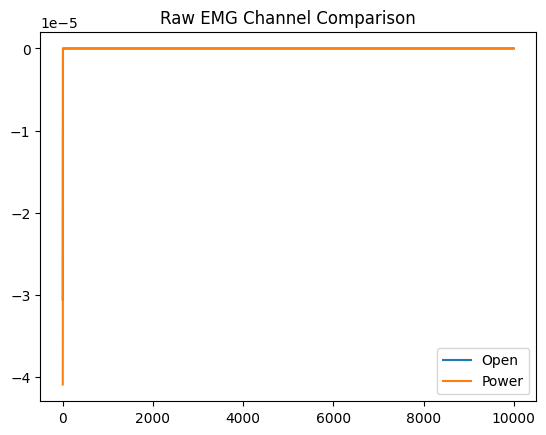

In [25]:
import matplotlib.pyplot as plt

ch = 0
plt.plot(X[y==0][0, ch, :], label="Open")
plt.plot(X[y==1][0, ch, :], label="Power")
plt.legend()
plt.title("Raw EMG Channel Comparison")
plt.show()


In [26]:
import numpy as np
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


{0: 800, 1: 800}


In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 10 labels:", y[:10])


X shape: (1600, 16, 10000)
y shape: (1600,)
First 10 labels: [1 1 1 1 1 0 0 0 0 0]


In [32]:
#check block labels have different signals
# Get indices of first open and first power trial
i_open  = np.where(y == 0)[0][0]
i_power = np.where(y == 1)[0][0]

print("Open trial index:", i_open)
print("Power trial index:", i_power)

# Compare raw numbers
diff = np.max(np.abs(X[i_open, 0, :] - X[i_power, 0, :]))
print("Max absolute difference between open/power on channel 0:", diff)


Open trial index: 5
Power trial index: 0
Max absolute difference between open/power on channel 0: 1.6906512e-05


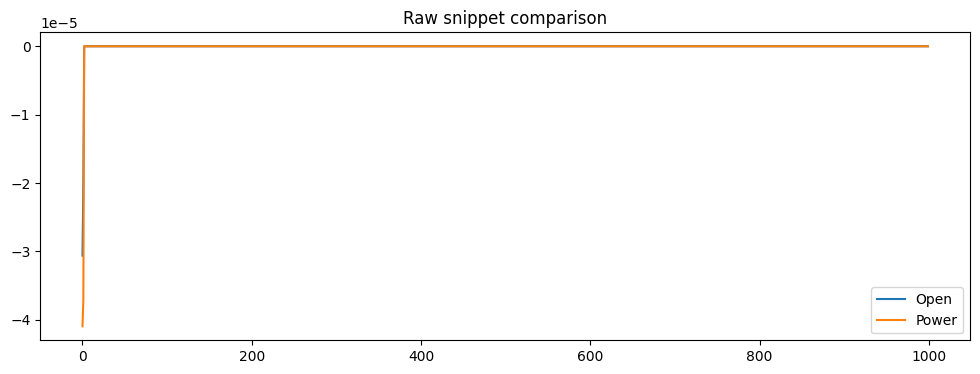

In [34]:
plt.figure(figsize=(12,4))
plt.plot(X[i_open, 0, :1000], label="Open")
plt.plot(X[i_power, 0, :1000], label="Power")
plt.legend()
plt.title("Raw snippet comparison")
plt.show()


# Reshape for Conv1D

In [16]:
# Swap axes: (N, 16, 10000) -> (N, 10000, 16)
X_train = np.transpose(X_train_norm, (0, 2, 1))
X_test  = np.transpose(X_test_norm,  (0, 2, 1))

print("Conv1D input shape:", X_train.shape)  # (n_train, 10000, 16)


Conv1D input shape: (1120, 10000, 16)


# Build the Model (Conv1D)

In [17]:
input_shape = X_train.shape[1:]  # (10000, 16)
#good model end of day 4
model= Sequential([
    layers.Input(shape=input_shape),

    # Block 1
    layers.Conv1D(32, kernel_size=7, padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=4),

    # Block 2
    layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=4),

    # Block 3
    layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=4),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary output: P(power grasp)
])


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10000, 32)      │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2500, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 625, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 625, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 156, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,278,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,825 (5.03 MB)

 Trainable params: 1,317,825 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'recall', 'precision']
)


In [19]:
es = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [20]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1,
)


Epoch 1/100
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5076 - loss: 0.7022 - precision: 0.4277 - recall: 0.2348

KeyboardInterrupt: 

# Evaluation Block (Confusion Matrix + Report)

In [ ]:
print("\n===== Test Performance =====")
results = model.evaluate(X_test, y_test, verbose=0)

for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)  # keep threshold=0.5

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=["open (0)", "power (1)"]
))

prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
print(f"\nPrecision (power=1): {prec:.4f}")
print(f"Recall    (power=1): {rec:.4f}")



===== Test Performance =====
loss: 0.5773
compile_metrics: 0.7229
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Confusion Matrix:
[[166  74]
 [ 59 181]]

Classification Report:
              precision    recall  f1-score   support

    open (0)       0.74      0.69      0.71       240
   power (1)       0.71      0.75      0.73       240

    accuracy                           0.72       480
   macro avg       0.72      0.72      0.72       480
weighted avg       0.72      0.72      0.72       480


Precision (power=1): 0.7098
Recall    (power=1): 0.7542


In [ ]:
# from sklearn.metrics import precision_recall_fscore_support
# probs = model.predict(X_test).ravel()
# thresholds = np.linspace(0.3, 0.7, 9)

# best_t = 0.5
# best_f1 = 0

# for t in thresholds:
#     preds = (probs > t).astype(int)
#     prec, rec, f1, _ = precision_recall_fscore_support(
#         y_test, preds, average='binary'
#     )
#     print(f"t={t:.2f}  precision={prec:.3f}  recall={rec:.3f}  f1={f1:.3f}")

#     if f1 > best_f1:
#         best_f1 = f1
#         best_t = t

# print("Best threshold:", best_t)

In [ ]:
# import numpy as np
# from pathlib import Path

# PROJECT_ROOT = Path("/Users/loso/code/hildieleyser/inkling")
# ARTIFACTS_DIR = PROJECT_ROOT / "zaki_EMG_packages" / "artifacts"
# ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# scaler_path = ARTIFACTS_DIR / "emg_scaler.npz"

# np.savez(
#     scaler_path,
#     mean=train_mean.astype("float32"),
#     std=train_std.astype("float32"),
# )

# print("Scaler saved:", scaler_path)


Scaler saved: /Users/loso/code/hildieleyser/inkling/zaki_EMG_packages/artifacts/emg_scaler.npz
